In [1]:
import os
import timeit

import cv2
from tensorflow.keras.backend import clear_session
import numpy as np
from PIL import Image
from scipy.stats import entropy, norm

import image_process as ip
import tools as tl
import tensorflow as tf
from tensorflow.keras.applications import Xception
import gc
import models
from tensorflow.keras.optimizers import Adam
from keras_bcnn.models import BayesianUNet2D
from matplotlib import pylab as plt
from scipy.stats import entropy
from tensorflow.keras.utils import plot_model
from keras_bcnn.models import MCSampler
import scipy.misc
from tensorflow.keras.layers import Input, Lambda,Reshape,Activation
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

Using TensorFlow backend.


In [2]:
data='melanoma'
mode='train'
data_num=1
method='unet_patch'
patch_size=160
test_slide_step=10
ite=10
n_class=2
reflect=False
model_name='unet'
save_path = tl.get_save_path(data, method, 'unet',patch_size, data_num)

In [3]:
for data_num in [1,2,3,4,5]:
    save_path = tl.get_save_path(data, method, 'unet',patch_size, data_num)
    for mode in ["test"] : 
        os.makedirs(save_path + '%s_un/uncertainty'%mode, exist_ok=True)
        os.makedirs(save_path + '%s_un/uncertainty_T_0.5'%mode, exist_ok=True)
        os.makedirs(save_path+"%s"%mode, exist_ok=True)
        os.makedirs(save_path+"label", exist_ok=True)
        os.makedirs(save_path + '%s_un/correctness'%mode, exist_ok=True)
        os.makedirs(save_path + '%s_un/probability'%mode, exist_ok=True)

In [20]:
for data_num in [1,2,3,4,5]:
    save_path = tl.get_save_path(data, method, 'unet',patch_size, data_num)
    for mode in ["test"] : 
        os.makedirs(save_path + 'stage2/%s_un/uncertainty'%mode, exist_ok=True)
        os.makedirs(save_path + 'stage2/%s_un/uncertainty_T_0.5'%mode, exist_ok=True)
        os.makedirs(save_path+"stage2/%s"%mode, exist_ok=True)
        os.makedirs(save_path+"stage2/label", exist_ok=True)
        os.makedirs(save_path + 'stage2/%s_un/correctness'%mode, exist_ok=True)
        os.makedirs(save_path + 'stage2/%s_un/probability'%mode, exist_ok=True)

In [4]:
def get_ytrue(mask_array, data):
        if data == "ips":
            height, width, _ = mask_array.shape
            good_label = ((mask_array[:,:,0] == 255)&
                          (mask_array[:,:,1] == 0)&
                          (mask_array[:,:,2] == 0)
                         ) * np.ones((height, width)) * 1
            bad_label = ((mask_array[:,:,0] == 0)&
                         (mask_array[:,:,1] == 255)&
                         (mask_array[:,:,2] == 0)
                        ) * np.ones((height, width)) * 2
            bgd_label = ((mask_array[:,:,0] == 0)&
                         (mask_array[:,:,1] == 0)&
                         (mask_array[:,:,2] == 255)
                        ) * np.ones((height, width)) * 3
            y_true = good_label + bad_label + bgd_label
            return y_true
        else:
            height, width = mask_array.shape
            y_true = (mask_array == 255) * np.ones((height, width))
            return y_true

In [5]:
def make_prediction_map(size, test_step, width, height, pre_map, ref_num, reflect, data, n_class):
    print("Start visualize image...")
    num = 0
    if reflect:
        height += ref_num*2
        width += ref_num*2
    pre_label = np.zeros((height,width,n_class))
    for y in range(0,height-size+1,test_step):
        for x in range(0,width-size+1,test_step):
            patch = np.ones((size,size,n_class))
            patch = patch*pre_map[num]
            pre_label[y:y+size,x:x+size,:] += patch
            num += 1
    sumaltion=np.sum(pre_label,axis=2)
    pre_label[:,:,0]=pre_label[:,:,0]/sumaltion
    pre_label[:,:,1]=pre_label[:,:,1]/sumaltion
    pro = pre_label.copy()
    pro = pro*255
    e=entropy(pre_label,axis=2)
    if data in ['ips']:
        vis_img, label_img = tl.get_InfImg(pre_label, data)
    elif data in ['melanoma', 'colonoscopy_tissue']:
        others = pre_label[:,:,0]
        target = pre_label[:,:,1]
        label_img = (target > others)*1
        vis_img = label_img*255
    if reflect:
        vis_img = vis_img[ref_num:height-ref_num,ref_num:width-ref_num]
        label_img = label_img[ref_num:height-ref_num,ref_num:width-ref_num]
    return vis_img, label_img,e, pro

In [6]:
def convert2label(name, save_path):
    mask = np.array(Image.open(save_path+"test/" + name + '.png'), dtype=int)
    label = mask / 255
    if data == 'ips':
        label = label[:, :, 0] * 1 + label[:, :, 1] * 2 + label[:, :, 2] * 3
        label = Image.fromarray(np.uint8(label))
        label.save(save_path + '/label/' + name + '.png')
    else:
        label = Image.fromarray(np.uint8(label))
        label.save(save_path + '/label/' + name + '.png')

In [7]:
#prediction, label map, uncertainty mapの作成
for data_num in [1,2,3,4,5]:
    clear_session()
    save_path = tl.get_save_path(data, method, 'unet',patch_size, data_num)
    save_path = save_path+'stage2/'#stage3/stage4/'
    model = BayesianUNet2D((patch_size, patch_size, 3), 2).build()
    model.load_weights(save_path+'weights/weights.h5')
    n_class=2
    for mode in ["test"] :#,"train"
        if mode == "test":
            step=40
        else:
            step=100
        img_path, mask_path = tl.data_path_load(data,mode,data_num)
        ImageLoader = ip.PatchImageLoader(img_path,patch_size,step,data,mode)
        for i_path in img_path:
            print("************************************")
            print(i_path)
            name = os.path.basename(i_path)[:-4]
            X_test, width, height = ImageLoader.crop_one_img(i_path, patch_size, reflect)
            X_test = np.array(X_test) / 255.
            Yp=0
            for i in range(ite):
                Yp += model.predict(X_test)
            Yp/=ite
            del X_test
            gc.collect()
            print("Predict finish")
            vis_img, label_img,e,pro = make_prediction_map(patch_size,
                                                             step,
                                                             width,
                                                             height,
                                                             Yp,
                                                             patch_size,
                                                             reflect,
                                                             data,
                                                             n_class)
            #vis_img = vis_img[:, :, [1, 0]]
            cv2.imwrite(save_path + '%s/' % mode+name + '.png', vis_img)
            probability = np.zeros((height,width,3))
            probability[:,:,0] = pro[:,:,0]
            probability[:,:,1] = pro[:,:,1]
            cv2.imwrite(save_path + '%s_un/probability/' % mode+name + '.png', probability)
            if mode == 'test':
                convert2label(name, save_path)
            e=np.nan_to_num(e)
            tmp =(e-e.min())/(e.max()-e.min())
            e_1=tmp*255
            e_1 = Image.fromarray(e_1)
            e_1 = e_1.convert('RGB')
            e_1.save(save_path + '%s_un/uncertainty/'%mode + name + '.png')
            tmp[tmp>=0.5]=255
            tmp[tmp<0.5]=0
            tmp=Image.fromarray(tmp)
            tmp = tmp.convert('RGB')
            tmp.save(save_path + '%s_un/uncertainty_T_0.5/'%mode + name + '.png')

            del Yp,vis_img, label_img,e,e_1,tmp,pro,probability
            gc.collect()
            print("************************************")

************************************
data/melanoma/img/ISIC_0000011.jpg


/home/sora/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/autograph/impl/api.py:493: UserWarning: Training option is ignored..
  return py_builtins.overload_of(f)(*args)


Predict finish
Start visualize image...


/home/sora/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/sora/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


************************************
************************************
data/melanoma/img/ISIC_0000018.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000024.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000038.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000064.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000066.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000073.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000079.j

************************************
************************************
data/melanoma/img/ISIC_0000485.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000486.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000492.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000496.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000499.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000505.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000506.j

************************************
************************************
data/melanoma/img/ISIC_0010020.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010024.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010032.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010040.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010042.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010044.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010053.j

************************************
************************************
data/melanoma/img/ISIC_0011118.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011126.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011130.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011136.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011137.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011157.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011166.j

************************************
************************************
data/melanoma/img/ISIC_0012460.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012469.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012489.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012501.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012503.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012517.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012529.j

************************************
************************************
data/melanoma/img/ISIC_0013235.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013244.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013249.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013294.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013302.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013311.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013316.j

************************************
************************************
data/melanoma/img/ISIC_0013980.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013984.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013995.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014026.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014044.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014081.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014082.j

************************************
************************************
data/melanoma/img/ISIC_0014763.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014779.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014782.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014803.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014821.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014830.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014832.j

************************************
************************************
data/melanoma/img/ISIC_0000262.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000264.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000275.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000278.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000288.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000294.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000302.j

************************************
************************************
data/melanoma/img/ISIC_0002489.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0002647.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0002948.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0002976.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0003005.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0003346.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0004309.j

************************************
************************************
data/melanoma/img/ISIC_0010330.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010365.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010435.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010442.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010463.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010468.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010475.j

************************************
************************************
data/melanoma/img/ISIC_0012442.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012487.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012520.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012523.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012549.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012659.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012664.j

************************************
************************************
data/melanoma/img/ISIC_0013184.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013189.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013198.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013229.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013238.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013257.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013268.j

************************************
************************************
data/melanoma/img/ISIC_0013965.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013983.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013986.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014001.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014031.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014032.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014046.j

************************************
************************************
data/melanoma/img/ISIC_0014730.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014731.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014748.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014754.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014778.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014785.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014793.j

************************************
************************************
data/melanoma/img/ISIC_0000107.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000116.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000122.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000127.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000130.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000136.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000139.j

************************************
************************************
data/melanoma/img/ISIC_0000473.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000482.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000490.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000491.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000501.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000503.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000523.j

************************************
************************************
data/melanoma/img/ISIC_0009939.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009940.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009969.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009972.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009973.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009977.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009981.j

************************************
************************************
data/melanoma/img/ISIC_0011089.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011101.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011102.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011114.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011132.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011211.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011212.j

************************************
************************************
data/melanoma/img/ISIC_0012653.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012669.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012673.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012675.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012679.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012681.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012685.j

************************************
************************************
data/melanoma/img/ISIC_0013618.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013656.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013671.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013672.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013682.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013712.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013719.j

************************************
************************************
data/melanoma/img/ISIC_0014543.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014570.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014576.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014581.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014592.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014607.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014613.j

************************************
************************************
data/melanoma/img/ISIC_0000048.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000049.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000050.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000056.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000059.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000063.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000075.j

************************************
************************************
data/melanoma/img/ISIC_0000338.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000344.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000346.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000347.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000348.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000355.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000370.j

************************************
************************************
data/melanoma/img/ISIC_0007038.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0008145.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0008396.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0008600.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0008626.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0008998.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009083.j

************************************
************************************
data/melanoma/img/ISIC_0010382.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010441.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010443.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010452.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010455.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010467.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010474.j

************************************
************************************
data/melanoma/img/ISIC_0012376.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012384.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012391.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012415.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012445.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012478.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012506.j

************************************
************************************
data/melanoma/img/ISIC_0013219.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013224.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013227.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013243.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013258.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013275.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013314.j

************************************
************************************
data/melanoma/img/ISIC_0014049.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014089.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014131.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014163.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014173.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014187.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014216.j

************************************
************************************
data/melanoma/img/ISIC_0015158.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0015181.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0015189.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0015204.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000020.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000027.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000036.j

************************************
************************************
data/melanoma/img/ISIC_0000265.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000268.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000277.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000295.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000297.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000311.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000315.j

************************************
************************************
data/melanoma/img/ISIC_0002453.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0002780.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0002871.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0003728.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0004110.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0004346.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0005187.j

************************************
************************************
data/melanoma/img/ISIC_0010081.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010086.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010087.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010090.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010102.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010104.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010174.j

************************************
************************************
data/melanoma/img/ISIC_0011140.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011144.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011146.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011159.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011161.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011162.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011163.j

************************************
************************************
data/melanoma/img/ISIC_0012662.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012666.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012697.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012699.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012704.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012711.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012756.j

************************************
************************************
data/melanoma/img/ISIC_0013554.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013568.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013599.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013603.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013621.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013635.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013664.j

************************************
************************************
data/melanoma/img/ISIC_0014682.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014685.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014745.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014771.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014794.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014802.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014823.j

In [7]:
def make_prediction_map(size, test_step, width, height, pre_map, pre_map2, ref_num, reflect, data, n_class):
    print("Start visualize image...")
    num = 0
    if reflect:
        height += ref_num*2
        width += ref_num*2
    pre_label = np.zeros((height,width,n_class))
    pre_label2 = np.zeros((height,width,n_class))
    pre_label3 = np.zeros((height,width,n_class))
    pre_map2=np.nan_to_num(pre_map2)
    for y in range(0,height-size+1,test_step):
        for x in range(0,width-size+1,test_step):
            patch = np.ones((size,size,n_class))
            patch2 = patch
            patch = patch*pre_map[num]
            patch3 = patch*pre_map2[num]
            pre_label[y:y+size,x:x+size,:] += patch
            pre_label2[y:y+size,x:x+size,:] += patch2
            pre_label3[y:y+size,x:x+size,:] += patch3
            num += 1
    pre_label = pre_label/pre_label2
    pre_label3 = pre_label3/pre_label2
    pro = pre_label.copy()
    probability=pre_label.copy()
    pro[pro >= 0.5]=1
    pro[pro < 0.5]=0
    vis_img = pro*255
    
    e=pre_label3*255#entropy(pre_label,axis=2)

    return vis_img,e, probability*255

************************************
data/melanoma/img/ISIC_0000207.jpg


/home/sora/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/autograph/impl/api.py:493: UserWarning: Training option is ignored..
  return py_builtins.overload_of(f)(*args)


Predict finish
Start visualize image...


/home/sora/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/sora/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/sora/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater_equal
/home/sora/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less


************************************
************************************
data/melanoma/img/ISIC_0000046.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009297.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013054.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012213.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012339.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010567.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009954.j

************************************
************************************
data/melanoma/img/ISIC_0000155.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011143.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000471.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014825.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013896.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014286.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000513.j

************************************
************************************
data/melanoma/img/ISIC_0000169.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000229.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014580.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000350.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009504.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013229.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009967.j

************************************
************************************
data/melanoma/img/ISIC_0013559.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011099.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013552.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000540.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014754.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014615.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000550.j

************************************
************************************
data/melanoma/img/ISIC_0014831.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013707.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014836.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000125.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000247.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013184.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009873.j

************************************
************************************
data/melanoma/img/ISIC_0013747.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013238.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012823.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012413.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000100.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0001128.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000310.j

************************************
************************************
data/melanoma/img/ISIC_0014072.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0015190.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009932.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014726.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014108.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013007.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009564.j

************************************
************************************
data/melanoma/img/ISIC_0014730.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012813.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014811.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013086.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012523.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014598.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011165.j

************************************
************************************
data/melanoma/img/ISIC_0000086.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013365.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000354.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012333.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012788.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013843.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009899.j

************************************
************************************
data/melanoma/img/ISIC_0003056.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000071.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000196.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000380.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000035.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012170.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000030.j

************************************
************************************
data/melanoma/img/ISIC_0010075.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0001133.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011218.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014527.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009969.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012217.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011212.j

************************************
************************************
data/melanoma/img/ISIC_0000127.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014775.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011300.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014290.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0006021.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014639.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012103.j

************************************
************************************
data/melanoma/img/ISIC_0010473.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013841.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009599.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0004168.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0005000.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0015219.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0002287.j

************************************
************************************
data/melanoma/img/ISIC_0014987.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0002251.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014628.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0015182.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013326.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000165.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000085.j

************************************
************************************
data/melanoma/img/ISIC_0000016.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000160.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000116.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014311.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000047.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013192.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000456.j

************************************
************************************
data/melanoma/img/ISIC_0014595.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013433.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009949.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010336.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000326.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000551.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011362.j

************************************
************************************
data/melanoma/img/ISIC_0014694.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010476.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014849.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014722.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000478.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012214.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000216.j

************************************
************************************
data/melanoma/img/ISIC_0013364.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012512.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013982.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000420.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000431.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010443.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000075.j

************************************
************************************
data/melanoma/img/ISIC_0013626.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000077.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013034.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012773.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014762.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000111.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011199.j

************************************
************************************
data/melanoma/img/ISIC_0014431.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010372.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012384.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013243.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013691.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014089.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0015045.j

************************************
************************************
data/melanoma/img/ISIC_0014596.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000285.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012518.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014819.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000019.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014216.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000276.j

************************************
************************************
data/melanoma/img/ISIC_0014739.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000344.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014804.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010028.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012282.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0008600.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000097.j

************************************
************************************
data/melanoma/img/ISIC_0010481.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0007760.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011164.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010334.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013174.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012107.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000342.j

************************************
************************************
data/melanoma/img/ISIC_0012845.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010448.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014802.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014606.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000065.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013134.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000052.j

************************************
************************************
data/melanoma/img/ISIC_0002780.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010346.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010081.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013088.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000476.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000237.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000297.j

************************************
************************************
data/melanoma/img/ISIC_0014890.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000067.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012495.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010498.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013635.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012527.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000040.j

************************************
************************************
data/melanoma/img/ISIC_0011144.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010350.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011393.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000377.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000027.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013695.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010847.j

************************************
************************************
data/melanoma/img/ISIC_0010227.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011219.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011146.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000036.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0010057.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0011090.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000149.j

************************************
************************************
data/melanoma/img/ISIC_0008807.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013026.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000516.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0015284.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013603.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012827.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0000134.j

************************************
************************************
data/melanoma/img/ISIC_0014174.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009889.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0014983.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0006982.jpg
Predict finish
Start visualize image...
************************************


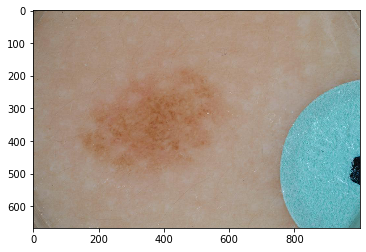

In [8]:
step=50
mc_iteration=10
output_channel=1
for data_num in [2,3,4,5]:
    clear_session()
    save_path = tl.get_save_path(data, method, 'unet',patch_size, data_num)
    
    model = BayesianUNet2D((patch_size, patch_size, 3), output_channel).build()
    model.load_weights(save_path+'weights/weights.h5')
    input_shape = (patch_size,patch_size,3)
    inputs2 = Input(input_shape)
    mc_samples = Lambda(lambda x: K.repeat_elements(x, mc_iteration, axis=0))(inputs2)
    logits = model(mc_samples)
    ret_shape = model.layers[-1].output_shape
    ret_shape = (-1, mc_iteration, *ret_shape[1:])
    probs = Lambda(lambda x: K.reshape(x, ret_shape))(logits)
    mean = Lambda(lambda x: K.mean(x, axis=1))(probs)
    variance = Lambda(lambda x: K.var(x, axis=1))(probs)
    model2 = Model(inputs=inputs2, outputs=[mean,variance])
        
    for mode in ["test"]:
        img_path, mask_path = tl.data_path_load(data,mode,data_num)
        
        for i_path in img_path:
            print("************************************")
            print(i_path)
            img = Image.open(i_path)
            width,height=img.size
            plt.imshow(img)
            img = np.array(img) / 255.
            name = os.path.basename(i_path)[:-4]
            Yp=[]
            Yp2=[]
            y=0
            while y < (height - patch_size + 1):
                x = 0
                while x < (width - patch_size + 1):
                    crop_img = img[y:patch_size+y, x:patch_size+x]
                    tmp,tmp2 = model2.predict(crop_img[np.newaxis, :, :, :])
                    
                    tmp = np.reshape(tmp, (patch_size,patch_size,1))
                    tmp2 = np.reshape(tmp2, (patch_size,patch_size,1))
                    Yp.append(tmp)
                    Yp2.append(tmp2)
                    del crop_img,tmp,tmp2
                    gc.collect()
                    x+=step   
                y+=step
            Yp = np.array(Yp)
            Yp2 = np.array(Yp2)
            print("Predict finish")
            vis_img,e,pro = make_prediction_map(patch_size,
                                                             step,
                                                             width,
                                                             height,
                                                             Yp,
                                                             Yp2,
                                                             patch_size,
                                                             reflect,
                                                             data,
                                                             1)
            #vis_img = vis_img[:, :, [1, 0]]
            cv2.imwrite(save_path + '%s/' % mode+name + '.png', vis_img)
            cv2.imwrite(save_path + '%s_un/probability/' % mode+name + '.png', pro)
            if mode == 'test':
                convert2label(name, save_path)
            e=np.nan_to_num(e)
            tmp =(e-e.min())/(e.max()-e.min())
            e_1=tmp*255
            #e_1 = Image.fromarray(e_1)
            #e_1 = e_1.convert('RGB')
            #e_1.save(save_path + '%s_un/uncertainty/'%mode + name + '.png')
            cv2.imwrite(save_path + '%s_un/uncertainty/' % mode+name + '.png', e_1)
            e_1[e_1>=0.5]=255
            e_1[e_1<0.5]=0
            cv2.imwrite(save_path + '%s_un/uncertainty_T_0.5/' % mode+name + '.png', e_1)

            del Yp,Yp2,vis_img,e,e_1,tmp,pro
            gc.collect()
            print("************************************")
    del model,model2,input_shape,mean,variance,probs,mc_samples,logits,ret_shape
    gc.collect()

In [9]:
def pre_data_path_load(path):
    """
    data: str, "ips" or "melanoma"
    mode: str, "train" or "test"
    d_num: int, 1, ..., 5
    """
    img_path=[]
    if data in ['ips', 'melanoma']:
        for x in os.listdir(path):
            img_path.append(path+x)
        return img_path

In [10]:
#correctness mapの作成
for data_num in [1,2,3,4,5]:
    save_path = tl.get_save_path(data, method, 'unet',patch_size, data_num)
    save_path = save_path#+"stage2/"
    mode="test"
    img_path, mask_path = tl.data_path_load(data,mode,data_num)
    path=("./%s/%s/%s/size_%d/dataset_%d/" %(data, method,model_name,patch_size,data_num))
    #path=("./%s/%s/%s/size_%d/dataset_%d/stage2/" %(data, method,model_name,patch_size,data_num))
    pre_path = pre_data_path_load(path+"%s/"%mode)
    mask_path.sort()
    pre_path.sort()
    for m_path,p_path in zip(mask_path,pre_path):
        name = os.path.basename(m_path)[:-4]
        print(name)
        m_mask = cv2.imread(m_path)
        m_mask = cv2.cvtColor(m_mask, cv2.COLOR_BGR2RGB)
        height, width = m_mask.shape[:2]

        p_image = cv2.imread(p_path)
        p_image = cv2.cvtColor(p_image, cv2.COLOR_BGR2RGB)
        true=m_mask-p_image
        true[true!=0]=255
        true=Image.fromarray(true)
        true = true.convert('RGB')
        true.save(save_path + 'test_un/correctness/' + name + '.png')

ISIC_0000011
ISIC_0000018
ISIC_0000024
ISIC_0000038
ISIC_0000064
ISIC_0000066
ISIC_0000073
ISIC_0000079
ISIC_0000087
ISIC_0000091
ISIC_0000092
ISIC_0000102
ISIC_0000104
ISIC_0000108
ISIC_0000118
ISIC_0000126
ISIC_0000156
ISIC_0000162
ISIC_0000172
ISIC_0000174
ISIC_0000185
ISIC_0000190
ISIC_0000203
ISIC_0000214
ISIC_0000226
ISIC_0000227
ISIC_0000245
ISIC_0000256
ISIC_0000260
ISIC_0000269
ISIC_0000298
ISIC_0000301
ISIC_0000313
ISIC_0000322
ISIC_0000323
ISIC_0000341
ISIC_0000359
ISIC_0000367
ISIC_0000376
ISIC_0000382
ISIC_0000396
ISIC_0000409
ISIC_0000412
ISIC_0000418
ISIC_0000426
ISIC_0000427
ISIC_0000439
ISIC_0000442
ISIC_0000445
ISIC_0000458
ISIC_0000463
ISIC_0000465
ISIC_0000466
ISIC_0000467
ISIC_0000469
ISIC_0000480
ISIC_0000485
ISIC_0000486
ISIC_0000492
ISIC_0000496
ISIC_0000499
ISIC_0000505
ISIC_0000506
ISIC_0000518
ISIC_0000520
ISIC_0000535
ISIC_0000545
ISIC_0000547
ISIC_0000552
ISIC_0000900
ISIC_0001140
ISIC_0002438
ISIC_0002673
ISIC_0002829
ISIC_0002975
ISIC_0003051
ISIC_0003308

ISIC_0012772
ISIC_0012813
ISIC_0012814
ISIC_0012823
ISIC_0012835
ISIC_0012887
ISIC_0012901
ISIC_0012907
ISIC_0012939
ISIC_0012969
ISIC_0013007
ISIC_0013024
ISIC_0013032
ISIC_0013039
ISIC_0013040
ISIC_0013048
ISIC_0013053
ISIC_0013054
ISIC_0013055
ISIC_0013075
ISIC_0013086
ISIC_0013089
ISIC_0013129
ISIC_0013147
ISIC_0013160
ISIC_0013163
ISIC_0013165
ISIC_0013166
ISIC_0013167
ISIC_0013177
ISIC_0013184
ISIC_0013189
ISIC_0013198
ISIC_0013229
ISIC_0013238
ISIC_0013257
ISIC_0013268
ISIC_0013288
ISIC_0013304
ISIC_0013315
ISIC_0013334
ISIC_0013341
ISIC_0013346
ISIC_0013370
ISIC_0013397
ISIC_0013398
ISIC_0013400
ISIC_0013403
ISIC_0013423
ISIC_0013428
ISIC_0013437
ISIC_0013443
ISIC_0013486
ISIC_0013490
ISIC_0013517
ISIC_0013526
ISIC_0013552
ISIC_0013559
ISIC_0013567
ISIC_0013573
ISIC_0013581
ISIC_0013585
ISIC_0013592
ISIC_0013594
ISIC_0013597
ISIC_0013652
ISIC_0013707
ISIC_0013713
ISIC_0013747
ISIC_0013775
ISIC_0013782
ISIC_0013800
ISIC_0013805
ISIC_0013806
ISIC_0013835
ISIC_0013862
ISIC_0013876

ISIC_0000336
ISIC_0000338
ISIC_0000344
ISIC_0000346
ISIC_0000347
ISIC_0000348
ISIC_0000355
ISIC_0000370
ISIC_0000372
ISIC_0000379
ISIC_0000385
ISIC_0000386
ISIC_0000387
ISIC_0000390
ISIC_0000407
ISIC_0000420
ISIC_0000423
ISIC_0000431
ISIC_0000447
ISIC_0000448
ISIC_0000449
ISIC_0000451
ISIC_0000453
ISIC_0000478
ISIC_0000483
ISIC_0000484
ISIC_0000494
ISIC_0000498
ISIC_0000500
ISIC_0000504
ISIC_0000508
ISIC_0000509
ISIC_0000517
ISIC_0000521
ISIC_0000527
ISIC_0000528
ISIC_0000532
ISIC_0000533
ISIC_0000534
ISIC_0000536
ISIC_0000549
ISIC_0000551
ISIC_0000882
ISIC_0001100
ISIC_0001142
ISIC_0002107
ISIC_0002353
ISIC_0002374
ISIC_0002476
ISIC_0002806
ISIC_0003174
ISIC_0004115
ISIC_0006350
ISIC_0006795
ISIC_0006800
ISIC_0006940
ISIC_0007038
ISIC_0008145
ISIC_0008396
ISIC_0008600
ISIC_0008626
ISIC_0008998
ISIC_0009083
ISIC_0009344
ISIC_0009860
ISIC_0009877
ISIC_0009883
ISIC_0009885
ISIC_0009891
ISIC_0009906
ISIC_0009909
ISIC_0009911
ISIC_0009925
ISIC_0009930
ISIC_0009942
ISIC_0009949
ISIC_0009965

ISIC_0013079
ISIC_0013084
ISIC_0013087
ISIC_0013088
ISIC_0013094
ISIC_0013114
ISIC_0013121
ISIC_0013134
ISIC_0013174
ISIC_0013178
ISIC_0013200
ISIC_0013217
ISIC_0013222
ISIC_0013248
ISIC_0013330
ISIC_0013360
ISIC_0013371
ISIC_0013378
ISIC_0013385
ISIC_0013390
ISIC_0013405
ISIC_0013417
ISIC_0013430
ISIC_0013461
ISIC_0013488
ISIC_0013492
ISIC_0013530
ISIC_0013554
ISIC_0013568
ISIC_0013599
ISIC_0013603
ISIC_0013621
ISIC_0013635
ISIC_0013664
ISIC_0013675
ISIC_0013695
ISIC_0013749
ISIC_0013795
ISIC_0013803
ISIC_0013807
ISIC_0013815
ISIC_0013816
ISIC_0013845
ISIC_0013864
ISIC_0013865
ISIC_0013879
ISIC_0013921
ISIC_0013933
ISIC_0013936
ISIC_0013961
ISIC_0013962
ISIC_0013970
ISIC_0013971
ISIC_0013972
ISIC_0013996
ISIC_0014013
ISIC_0014045
ISIC_0014066
ISIC_0014074
ISIC_0014093
ISIC_0014114
ISIC_0014157
ISIC_0014169
ISIC_0014174
ISIC_0014229
ISIC_0014316
ISIC_0014324
ISIC_0014347
ISIC_0014361
ISIC_0014372
ISIC_0014397
ISIC_0014432
ISIC_0014453
ISIC_0014507
ISIC_0014515
ISIC_0014518
ISIC_0014557